# Part 6 - Semantic Embeddings

#### Name: Amirhossein Kiani
#### Contact: ahosseinkiani@gmail.com

In this notebook, I focus on the text data available in the recipes dataset. In particular, preprocess the available text data, extract vectors representations of the preprocessed data using OpenAI's `ada-002` model. I will then assess the embeddings by comparing recipes that are found similar based on their embeddings (using cosine similarity). In the end, I craft a basic content-based recommendation system that receives user recipe inputs (ingredients, instructions, etc) and returns the top-5 recipes in the dataset that are most similar to it.

The notebook carries out this these steps in two phases:
1. the experimental phase where we work with a very small chunk of our dataset to assess the embdeddings based on initial preprocessing of the data,
2. the final phase where we incorporate the lessons learned from the experimental phase to improve the embdeddings and scale the task.

**NOTE:** You can start from Part 2 completely independently of Part 1; the latter only informs the process of creating our initial embeddings and the need to improve them.

Here's a table of contents with clickable links for convenience:

### Table of Contents:

#### [1. Experimentation](#exp)
- [1.1. Imports and Sanity Checks](#1.1)
- [1.2. Data Cleaning and Feature Engineering](#1.2)
- [1.3. Data Preprocessing](#1.3)
- [1.4. Document Embeddings](#1.4)
- [1.4.1. OpenAI Embeddings: `text-embedding-ada-002`](#1.4.1)
- [1.4.2. Connecting to the API](#1.4.2)
- [1.4.3. Inspect Embeddings](#1.4.3)
- [1.5. Creating a Recommender System](#1.5)

#### [2. Enhancing the Embeddings](#enhanc)
- [2.1. Imports and Sanity Checks](#2.1)
- [2.2. Preprocessing the Data](#2.2)
- [2.3. Document Embeddings](#2.3)
- [2.3.1. OpenAI Embeddings: `text-embedding-ada-002`](#2.3.1)
- [2.3.2. Connecting to the API](#2.3.2)
- [2.3.3. Inspect Embeddings](#2.3.3)
- [2.4. Creating a Recommender System](#2.4)

#### [3. Conclusion](#conc)

# 1. Experimentation<a class ='author' id='exp'></a>

## 1.1. Imports and Sanity Checks <a class ='author' id='1.1'></a>

In [47]:
# Making sure I'm in the right environment

import sys
sys.executable

'C:\\Users\\mathe\\anaconda3\\envs\\deepchef\\python.exe'

In [48]:
# Import typical datas science libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random

# Set the random seed

random.seed(42)
np.random.seed(42)

# Hide warnings

import warnings
warnings.filterwarnings('ignore')

In [49]:
# This allows scrolling through all the columns. Useful for dataframes with too many columns

pd.set_option('display.max_columns', 100)

In [72]:
recipes = pd.read_parquet('BasicCleanData.parquet')

In [73]:
recipes.sample()

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating
310306,322207.0,Apple Friendship Bread,736108,RedheadAblaze,Make and share this Apple Friendship Bread rec...,[],Baked Goods,"[Breads, Sweet, Beginner Cook, < 4 Hours, Easy]","[1 1⁄2, 3, 1 1⁄2, 1, 1⁄2, 1⁄2, 1⁄2, 1, 2, 1⁄2,...","[eggs, baking powder, baking soda, milk, vanil...",1.0,824.5,40.5,6.3,108.6,980.0,108.9,2.8,73.7,8.3,NaN,"[To the batter add the apples, eggs, baking po...",https://www.food.com/recipe/Apple-Friendship-B...,"[1 1⁄2, 3, 1 1⁄2, 1, 1⁄2, 1⁄2, 1⁄2, 1, 2, 1⁄2,...",[cups amish starter (see recipezaar.com/321840...,2008,8,29,19,75,5.0


In [55]:
recipes.shape

(522512, 28)

In [74]:
# Check to see how many null values we have for each column

recipes.isna().sum()

RecipeId                           0
Name                               0
AuthorId                           0
AuthorName                         0
Description                        0
Images                             0
RecipeCategory                     0
Keywords                           0
RecipeIngredientQuantities         0
RecipeIngredientParts              0
ReviewCount                   246698
Calories                           0
FatContent                         0
SaturatedFatContent                0
CholesterolContent                 0
SodiumContent                      0
CarbohydrateContent                0
FiberContent                       0
SugarContent                       0
ProteinContent                     0
RecipeServings                182733
RecipeInstructions                 0
url                                0
ingred_quants                      0
ingred_items                       0
YearPublished                      0
MonthPublished                     0
D

## 1.2. Data Cleaning and Feature Engineering<a class ='author' id='1.2'></a>

We want to use recipe images in our recommendation system, so let's drop recipes that have no images. 

In [21]:
# We have no None value for the Images column, but neverthesless some are just empty lists. 
# We want to filter those out.

filtered_recipes = recipes[recipes['Images'].apply(lambda x: len(x) != 0)]

In [22]:
filtered_recipes = filtered_recipes.reset_index(drop=True)

In [24]:
filtered_recipes.shape

(165535, 31)

## 1.3. Data Preprocessing <a class ='author' id='1.3'></a>

In this section, we engage with natrual language processing. **Natural Language Processing** (**NLP**) is a field of artificial intelligence that focuses on enabling computers to understand, interpret, and generate human language. It involves a wide range of operations to process and analyze text data. The code provided above demonstrates some of the essential operations performed in NLP for text preprocessing. The given script leverages the contractions, nltk, and spacy libraries to carry out these tasks.

The following `preprocess_text` function first converts the input text to lowercase to ensure uniformity. Then, it tokenizes the text, extracting individual words from the string. Next, it removes common English stop words, such as "the," "and," "is," etc., as they typically carry less meaning for analysis. The function then applies stemming using the Porter Stemmer algorithm, reducing words to their base or root forms. Furthermore, it performs lemmatization, a more advanced word normalization technique that converts words to their dictionary form. Finally, it eliminates punctuation marks from the preprocessed text to make it more suitable for further analysis.

Here are short definitions and examples of the concepts mentioned:

**Stemming:**

- Definition: Stemming is the process of reducing words to their base or root form by removing suffixes or prefixes. It aims to group words with similar meanings under the same root word.
- Example: The stem of the words "running," "runs," and "runner" is "run."

**Lemmatization:**

- Definition: Lemmatization is the process of converting words to their dictionary or base form (lemma). Unlike stemming, lemmatization considers the context of the word and produces valid words that make sense.
- Example: The lemma of the words "was," "were," and "am" is "be."

**Stopwords:**

- Definition: Stopwords are common words like "the," "and," "is," etc., that are frequently used in a language but carry little meaning. They are often removed from the text to reduce noise in NLP tasks.
- Example: In the sentence "The quick brown fox jumps over the lazy dog," the stopwords are "the" and "over."

**Tokenization:**

- Definition: Tokenization is the process of breaking a text into individual words or tokens for analysis. It is a crucial step in NLP to make the text suitable for further processing.
- Example: The sentence "I love natural language processing" is tokenized into individual words: ["I", "love", "natural", "language", "processing"].

**Punctuation Removal:**
- Definition: Punctuation removal involves eliminating punctuation marks like periods, commas, exclamation marks, etc., from the text to simplify the analysis.
- Example: The text "Hello, world!" after punctuation removal becomes "Hello world."

Overall, the provided script showcases a series of crucial NLP operations that are vital for preparing text data before applying sophisticated language processing tasks such as sentiment analysis, topic modeling, or information retrieval. These preprocessing steps help improve the quality and accuracy of NLP models and enable effective communication between machines and humans in natural language.

In [27]:
#!pip install contractions
#!pip install spacy

import contractions
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import spacy
from nltk.stem import WordNetLemmatizer
import string


# Define stopwords
stop_words = set(stopwords.words('english'))
# Define lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the function to preprocess text names
def preprocess_text(text):

    """
    This function performs various operations on a given string in order to clean it up. It:
        - turns all the letters to lower case,
        - extracts all the word-tokens from the strings,
        - removes stop words from the tokens,
        - lemmatizes the list of tokens,
        - removes punctuations from the tokens.
    """
    
    # Lowercase the text
    no_name_text = text.lower()
    
    # Split the text into words
    words = no_name_text.split()
    
    # Remove stopwords
    no_stopword_text = [w for w in words if not w in stop_words]
    
    # Apply stemming to each word
    stemmed_text = [PorterStemmer().stem(word) for word in no_stopword_text]
    
    # Lemmatization
    lematized_text = [lemmatizer.lemmatize(token) for token in stemmed_text]
    
    # Concatenate everything together
    
    concat = ' '.join(lematized_text)
    
    # Create a translation table to remove punctuations
    translator = str.maketrans('', '', string.punctuation)
    
    # Remove punctuations from the concatenated text
    cleaned_text = concat.translate(translator)
    
    return cleaned_text

Let's test the function:

In [57]:
recipes.iloc[44987]['RecipeInstructions']

array(['Preheat oven to 350.',
       'Spray 10-inch springform pan and line bottom with parchment round.',
       'Spray again and dust with cocoa powder.',
       'Grind chocolate and almonds in food processor until fine.',
       'Cream butter and sugar.',
       'Add yolks one at a time, beating well.',
       'Add chocolate/almond mixture and blend well.',
       'Beat whites to soft peaks.',
       'Mix 1/3 of whites into chocolate mixture to lighten (it will be stiff).',
       'Fold remaining whites into chocolate mixture.',
       'Bake until tests done, about 30 minutes.', 'Cool.',
       'Unmold upside down on to platter.'], dtype=object)

In [29]:
preprocess_text(" ".join(list(recipes.iloc[44987]['RecipeInstructions'])))

'preheat oven 350 spray 10inch springform pan line bottom parchment round spray dust cocoa powder grind chocol almond food processor fine cream butter sugar add yolk one time beat well add chocolatealmond mixtur blend well beat white soft peaks mix 13 white chocol mixtur lighten it stiff fold remain white chocol mixture bake test done 30 minutes cool unmold upsid platter'

We now create a column that records the cleaned version of all the instructions in `RecipeInstructions`:

In [30]:
filtered_recipes['CleanInstructions'] = filtered_recipes['RecipeInstructions'].apply(lambda x: preprocess_text(" ".join(x)))

In [31]:
filtered_recipes[['RecipeInstructions','CleanInstructions']] 

,RecipeInstructions,CleanInstructions
0,"[Toss 2 cups berries with sugar., Let stand fo...",toss 2 cup berri sugar let stand 45 minutes st...
1,[Soak saffron in warm milk for 5 minutes and p...,soak saffron warm milk 5 minut pure blender ad...
2,"[Into a 1 quart Jar with tight fitting lid, pu...",1 quart jar tight fit lid put sugar lemon peel...
3,"[Drain the tofu, carefully squeezing out exces...",drain tofu care squeez excess water pat dri pa...
4,"[Mix everything together and bring to a boil.,...",mix everyth togeth bring boil reduc heat simme...
...,...,...
165530,"[Slice the apples, onion,fennel, and celery in...",slice apples onionfennel celeri crescents rese...
165531,[Season the slices of beef with salt and peppe...,season slice beef salt pepper heat oil castiro...
165532,"[In a large bowl, add ground beef, bacon, chee...",larg bowl add ground beef bacon cheese onions ...
165533,"[Add the Reese's cups and vodka to a blender.,...",add reese cup vodka blender cover blend smooth...


In [32]:
filtered_recipes.sample()

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,CleanInstructions
82488,257988.0,French Dip Soup (Rachael Ray),488594,Chelley-Chelle,Just saw this recipe on Rachael's talk show. ...,[https://img.sndimg.com/food/image/upload/w_55...,Vegetables,"[Vegetable, Meat, < 60 Mins]","[1, 2, 5, 4, None, 3, 1, 1⁄2, 6, 1⁄2, 1, None]","[extra virgin olive oil, unsalted butter, onio...",7.0,785.7,21.9,8.8,103.7,2068.5,91.7,6.3,11.5,51.8,4.0,[Heat a deep pot over medium to medium-high he...,https://www.food.com/recipe/French-Dip-Soup-(R...,"[1, 2, 5, 4, , 3, 1, 1⁄2, 6, 1⁄2, 1, ]","[tablespoon extra virgin olive oil (EVOO), tab...",2007,10,9,15,45,4.57,heat deep pot medium mediumhigh heat add evoo ...


## 1.4. Document Embeddings <a class ='author' id='1.4'></a>

Document embeddings offer a compelling approach to represent the essence of an entire document through a single vector, achieved by aggregating individual word embeddings. Typically, these word embeddings are combined by averaging their values or applying weights based on their significance, resulting in a comprehensive document embedding. Utilizing document embeddings presents several advantages over the traditional bag-of-words representation, as it enables the capture of richer semantic information about the documents, consequently leading to more accurate and effective clustering outcomes.

In the context of our specific application, we will harness the power of `OpenAI`'s state-of-the-art embedding model `ada-002` to generate our document embeddings. `OpenAI`'s sophisticated language models and embedding techniques will empower us to extract meaningful insights from the documents, allowing us to achieve higher accuracy and precision in our analyses. With `ada-002`'s advanced embeddings, we are well-equipped to derive valuable knowledge from large volumes of text data, making our approach to document representation and clustering remarkably robust and efficient. We will particularly use the embeddings to empower similarity comparisons between our recipes, and create a recommendation system off of that.

### 1.4.1. OpenAI Embeddings: `text-embedding-ada-002`<a class ='author' id='1.4.1'></a>

`OpenAI` provides a range of language models with varying levels of complexity and accuracy. To create a document embedding, we can use one of the OpenAI's embedding models to obtain the word embeddings for each token in the sequence. Once we have the word embeddings, we can aggregate them into a single document embedding using a method, such as averaging or concatenation.

We will use the `text-embedding-ada-002` model, which is known to be "better, cheaper, and simpler to use" than other existing models. According to `OpenAI` documentation for word embeddings, the `ada-002` embedding model can take up to 8,191 tokens as maximum input token. So, we need to check whether the tokens from any of the plot exceeds the maximum number.

In [34]:
# Create a new column that contains the number of tokens in the `clean_plot`

filtered_recipes['num_tokens'] = filtered_recipes['CleanInstructions'].apply(lambda x: len(x.split()))

<Axes: xlabel='num_tokens', ylabel='Count'>

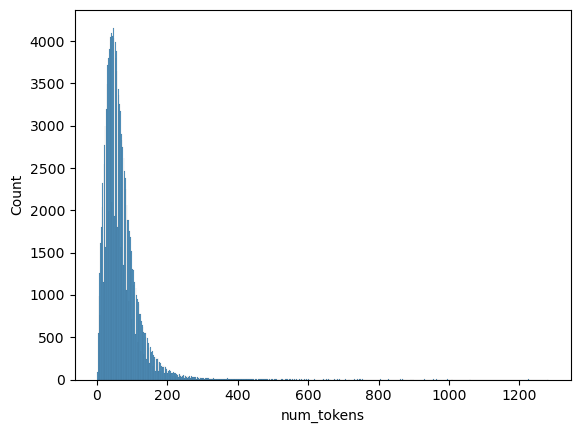

In [35]:
sns.histplot(filtered_recipes['num_tokens']);

In [36]:
# Find out the maximum and minimum number of tokens

max_tokens = filtered_recipes['num_tokens'].max()
min_tokens = filtered_recipes['num_tokens'].min()
print(f"Maximum number of tokens: {max_tokens}")
print(f"Minimum number of tokens: {min_tokens}")

Maximum number of tokens: 1282
Minimum number of tokens: 1


Strictly speaking, the number of tokens in our prepprocessed recipe instructions don't surpass the ~8,000 token limit of `ada-v2`. But in what follows I chop off the dataset to a much smaller fragment to just run the model on and assess the results. We can scale this if we find the experimental phase successful.

In [37]:
# Drop rows with `CleanInstructions` more than 300 tokens

filtered_recipes_300 = filtered_recipes[filtered_recipes['num_tokens']<300]

<Axes: xlabel='num_tokens', ylabel='Count'>

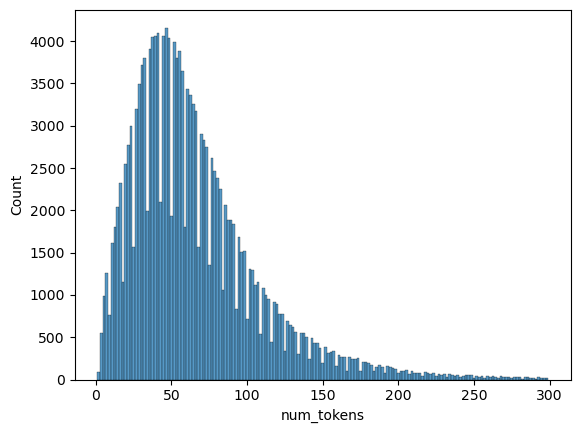

In [39]:
sns.histplot(filtered_recipes_300['num_tokens']);

In [40]:
# Find out the maximum and minimum number of tokens

max_tokens = filtered_recipes_300['num_tokens'].max()
min_tokens = filtered_recipes_300['num_tokens'].min()
print(f"Maximum number of tokens: {max_tokens}")
print(f"Minimum number of tokens: {min_tokens}")

Maximum number of tokens: 299
Minimum number of tokens: 1


In [ ]:
# Select one percent of the dataset for the experimental phase

filtered_recipes_1_precent = filtered_recipes_300.sample(frac=.01)

<Axes: xlabel='num_tokens', ylabel='Count'>

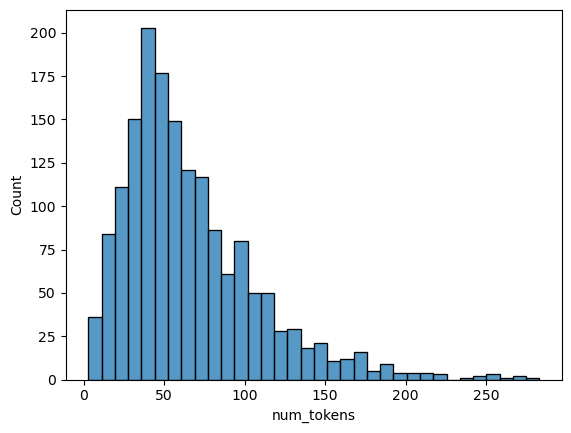

In [44]:
sns.histplot(filtered_recipes_1_precent['num_tokens'])

### 1.4.2. Connecting to the API<a class ='author' id='1.4.2'></a>

In this section we will set our API key and send a request to verify that we can send a request.
To do so, you need to get yourself a private API key first by signing up to create your account.

In [46]:
#!pip install tiktoken
#!pip install openai

In [9]:
import tiktoken 
import openai 

# Copy and paste your personal api key inbetween the quotation marks and then execute the below code
openai.api_key = "<insert your API key>"

In [10]:
# list models as a quick test
models = openai.Model.list()

# print the first model's id
print(models.data[0].id)

babbage


In [11]:
# Test if we can send a request

completion = openai.Completion.create(model="ada", prompt="Hello world")
print(completion['choices'][0].text)

. Color, by default, is set to: #FFFFFF."




In [12]:
# Import `get_embedding`
from openai.embeddings_utils import get_embedding

In [13]:
# Embedding model parameters

embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # This is the encoding for text-embedding-ada-002
max_tokens = 8000

In [14]:
from tenacity import retry, stop_after_attempt, wait_exponential

# Define the retry strategy using Tenacity
@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=30))

def get_embedding(text, engine="text-embedding-ada-002"):
    text = text.replace("\n", " ")
    response = openai.Embedding.create(input=[text], model=engine)
    embeddings = response['data'][0]['embedding']
    return embeddings

Let's test the embedding function:

In [15]:
input = 'preheat oven 350 spray 10inch springform pan line bottom parchment round spray dust cocoa powder grind chocol almond food processor fine cream butter sugar add yolk one time beat well add chocolatealmond mixtur blend well beat white soft peaks mix 13 white chocol mixtur lighten it stiff fold remain white chocol mixture bake test done 30 minutes cool unmold upsid platter'

In [16]:

get_embedding(input,engine=embedding_model)

[0.001518029486760497,
 -0.005900298245251179,
 -0.018982671201229095,
 -0.012577222660183907,
 -0.00351543677970767,
 0.015161395072937012,
 -0.008281722664833069,
 -0.027793599292635918,
 -0.026336565613746643,
 -0.012048017233610153,
 0.011683758348226547,
 0.019298819825053215,
 -0.05113362520933151,
 -0.02629532851278782,
 -0.014226693660020828,
 0.02133316919207573,
 0.031394947320222855,
 0.011539429426193237,
 -0.01576620154082775,
 -0.014721536077558994,
 -0.03356675058603287,
 0.01747065596282482,
 0.03241211920976639,
 0.00080111064016819,
 -0.012611586600542068,
 -0.007237057667225599,
 -0.0020515306387096643,
 -0.017429418861865997,
 -0.0058659338392317295,
 0.008103029802441597,
 0.013663124293088913,
 0.019436275586485863,
 -0.03323685750365257,
 -0.004841886926442385,
 -0.01528510544449091,
 -0.014817754738032818,
 -0.0158761665225029,
 -0.0030515228863805532,
 0.010151124559342861,
 -0.019821152091026306,
 0.005563531070947647,
 0.003048086306080222,
 0.003965605050325

In [ ]:
len(get_embedding(input,engine=embedding_model))

In [54]:
filtered_recipes_1_precent.shape

(1649, 33)

In [ ]:
import time
# Apply the get_embedding function with retries

start = time.time
# DO NOT RUN THE BELOW CODE UNLESS YOU WANT TO GET THE EMBEDDINGS FOR YOURSELF
#filtered_recipes_1_precent['ada_embeddings'] = filtered_recipes_1_precent['CleanInstructions'].apply(lambda x: get_embedding(x, engine=embedding_model))
end = time.time

duration = end-start
print(duration)
# Start: 19:52
# End: 19:57

In [75]:
filtered_recipes_1_precent.sample()

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,CleanInstructions,num_tokens,ada_embeddings
82305,257378.0,Cowboy Chicken Casserole,171084,CindiJ,We eat a lot of chicken dishes and thought thi...,[https://img.sndimg.com/food/image/upload/w_55...,Main Dish,"[Chicken Breast, Chicken, Poultry, Meat, Oven,...","[2, 2 1⁄2, 1⁄2, 1⁄4, 1 1⁄2, 2, 1, 1 1⁄4, 1⁄4, ...","[boneless skinless chicken breasts, dry white ...",6.0,743.7,41.6,19.8,157.5,1344.2,43.8,4.6,8.9,48.0,NaN,"[Combine the chicken, chicken stock, wine, cil...",https://www.food.com/recipe/Cowboy-Chicken-Cas...,"[2, 2 1⁄2, 1⁄2, 1⁄4, 1 1⁄2, 2, 1, 1 1⁄4, 1⁄4, ...","[lbs boneless skinless chicken breasts, cups c...",2007,10,6,18,160,4.83,combin chicken chicken stock wine cilantro lim...,218,"[0.012864918448030949, 0.004699717741459608, -..."


In [57]:
# Save the embeddings

filtered_recipes_1_precent.to_pickle('ada_embeddings_recipes_1_percent.pkl')

In [56]:
filtered_recipes_1_precent['ada_embeddings']

45982     [0.005560462828725576, -0.014354381710290909, ...
18648     [0.002844609320163727, -0.003990191034972668, ...
20210     [0.005943776573985815, 0.0031692134216427803, ...
76818     [-0.019190147519111633, -0.023121653124690056,...
116111    [-0.01205243170261383, 0.0012701272498816252, ...
                                ...                        
65663     [-0.013240563683211803, -0.012247174046933651,...
105527    [0.010186035186052322, -0.006703134626150131, ...
82931     [0.026219770312309265, 0.0031376739498227835, ...
59685     [0.026447683572769165, 0.003813009476289153, 0...
25523     [0.013756666332483292, 0.002341129584237933, -...
Name: ada_embeddings, Length: 1649, dtype: object

### 1.4.3. Inspect Embeddings <a class ='author' id='1.4.3'></a>
Now that we have word embeddings saved as a pickle file, we will read in the file and use it from now on.

In [76]:
# Load the embeddings

ada_1percent_df = pd.read_pickle('ada_embeddings_recipes_1_percent.pkl')

In [77]:
ada_1percent_df.sample()

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,CleanInstructions,num_tokens,ada_embeddings
137579,450108.0,Nancy's Turkey Stuffing,1745502,alvinakatz,I got this from my sister-in-law and it is sim...,[https://img.sndimg.com/food/image/upload/w_55...,Special Dietary Needs,"[Healthy, Kid Friendly, Free Of..., Thanksgivi...","[1, 1, 12, 1 1⁄2, 1, 1, 1]","[butter, onion, celery, salt, pepper, poultry ...",1.0,3617.2,99.2,47.2,162.7,8746.5,586.2,29.5,52.5,89.1,NaN,"[Melt the butter in a large, heavy skillet. Ad...",https://www.food.com/recipe/Nancy's-Turkey-Stu...,"[1, 1, 12, 1 1⁄2, 1, 1, 1]","[cup butter, cup onion, minced, cups dried bre...",2011,3,6,17,20,4.0,melt butter large heavi skillet add onion cook...,34,"[-0.0012128608068451285, 0.0002385434199823066..."


In [79]:
ada_1percent_df.sample()

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,CleanInstructions,num_tokens,ada_embeddings
11375,41038.0,Kosher Dill Okra Pickles,48065,Taylor in Belgium,Simple dilled okra pickles. This recipe can al...,[https://img.sndimg.com/food/image/upload/w_55...,Vegetables,"[Low Protein, Low Cholesterol, Healthy, < 60 M...","[3, 6, 3, 3, 6, 3, 12]","[okra, salt, vinegar, water, garlic, mustard s...",NaN,104.2,0.7,0.1,0.0,7000.2,17.6,7.6,2.9,5.2,NaN,"[Wash and drain okra., Prick each okra several...",https://www.food.com/recipe/Kosher-Dill-Okra-P...,"[3, 6, 3, 3, 6, 3, 12]","[lbs uniform sized okra, tablespoons salt, cup...",2002,9,24,22,45,NaN,wash drain okra prick okra sever time pin cut ...,56,"[0.014781979843974113, -0.0009912662208080292,..."


Let's expriment with the embeddings to see how our model functions well. Again, we will use the consine_distance function to get the most similar movies as well as the least similar movies.

In [80]:
ada_1percent_df = ada_1percent_df.reset_index(drop=True)

In [81]:
ada_1percent_df.sample()

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,CleanInstructions,num_tokens,ada_embeddings
226,153308.0,Grated Potato Pancakes,63858,LMillerRN,Make and share this Grated Potato Pancakes rec...,[https://img.sndimg.com/food/image/upload/w_55...,Breakfast/Brunch,"[Potato, Vegetable, Low Protein, Low Cholester...","[2, 2, None, None]","[idaho potatoes, canola oil, coarse salt, fres...",2.0,101.9,2.4,0.2,0.0,6.4,18.6,2.3,0.8,2.1,4.0,"[Peel potatoes, and grate on the large holes o...",https://www.food.com/recipe/Grated-Potato-Panc...,"[2, 2, , ]","[idaho potatoes, teaspoons canola oil, coarse ...",2006,1,25,15,20,5.0,peel potatoes grate larg hole box grater place...,86,"[0.012351969256997108, -0.002230031182989478, ..."


Let's see if our `cosine_similarity` function works as expected:

In [82]:
from sklearn.metrics.pairwise import cosine_similarity

In [83]:
s1 = get_embedding('John is happy')
s2 = get_embedding('John is very happy')
s3 = get_embedding('North Korea launches a missile')
s4 = get_embedding('The war between Russia and Ukrain is very sad.')

In [84]:
cosine_similarity_matrix_1 = cosine_similarity(np.array(s1).reshape(1, -1) ,np.array(s1).reshape(1, -1) )
cosine_similarity_value_1 = cosine_similarity_matrix_1[0, 0]

cosine_similarity_matrix_2 = cosine_similarity(np.array(s1).reshape(1, -1) ,np.array(s2).reshape(1, -1) )
cosine_similarity_value_2 = cosine_similarity_matrix_2[0, 0]

cosine_similarity_matrix_3 = cosine_similarity(np.array(s1).reshape(1, -1) ,np.array(s3).reshape(1, -1) )
cosine_similarity_value_3 = cosine_similarity_matrix_3[0, 0]

cosine_similarity_matrix_4 = cosine_similarity(np.array(s1).reshape(1, -1) ,np.array(s4).reshape(1, -1) )
cosine_similarity_value_4 = cosine_similarity_matrix_4[0, 0]

print(f"The cosine similarity between S1 and S1 is: {cosine_similarity_value_1}")
print(f"The cosine similarity between S1 and S2 is: {cosine_similarity_value_2}")
print(f"The cosine similarity between S1 and S3 is: {cosine_similarity_value_3}")
print(f"The cosine similarity between S1 and S4 is: {cosine_similarity_value_4}")

The cosine similarity between S1 and S1 is: 0.9999999999999993
The cosine similarity between S1 and S2 is: 0.9862178395181963
The cosine similarity between S1 and S3 is: 0.7599739841364809
The cosine similarity between S1 and S4 is: 0.7323427155294102


This seems to capture the similarities relatively fine, at least in comparison to one another; however, I would've expected less similarity between S1 and S3/S4 that what we see.

Now let's run comparsions between our recipes:

In [85]:
sample_recipe = ada_1percent_df[['CleanInstructions','ada_embeddings']].iloc[13,:] # Row with index=1
print(sample_recipe['CleanInstructions'])

arrang chicken piec slow cooker set aside combin sauc soup bowl blend well pour chicken cover cook low set 8 hour high 4 hours chicken tender shred 2 forks serv warm tortillas garnish desired


In [86]:
ada_1percent_df.shape[0]

1649

Let's find the closest recipe to the sample recipe, in terms of instructions:

In [87]:
max_distance = 0
row_index = 0
similarities = pd.DataFrame(columns=['similarity_scores'])

# Convert the string representation of the sample_plot embeddings to an actual NumPy array
sample_plot_embeddings = np.array(sample_recipe['ada_embeddings']).reshape(1, -1)

# Iterate through each row and compute the cosine distance between the sample_plot and all other plots
for row_index in ada_1percent_df.index:  
    
    # Convert the string representation of the array to an actual NumPy array
    cur_embeddings = np.array(ada_1percent_df['ada_embeddings'].iloc[row_index]).reshape(1, -1)
    
    # Compute the cosine distance between the sample plot and the current plot
    cur_distance = cosine_similarity(sample_plot_embeddings, cur_embeddings)
    
    similarities.at[row_index,'similarity_scores'] = cur_distance[0,0]

In [88]:
similarities.sort_values('similarity_scores',ascending=False)

,similarity_scores
13,1.0
997,0.930943
429,0.922279
521,0.904839
1168,0.901566
...,...
180,0.749656
1486,0.74885
437,0.747273
527,0.743632


Let's compare the `CleanInstructions` of the sample recipe and the recipe closest to it according to the results above:

In [33]:
# The sample recipe's CleanInstructions

print(sample_recipe['CleanInstructions'])

arrang chicken piec slow cooker set aside combin sauc soup bowl blend well pour chicken cover cook low set 8 hour high 4 hours chicken tender shred 2 forks serv warm tortillas garnish desired


In [356]:
# The sample recipe's RecipeInstructions

#ada_1percent_df[ada_1percent_df['CleanInstructions']==sample_plot['CleanInstructions']]['RecipeInstructions'].values

In [34]:
# The closest recipe's CleanInstructions

ada_1percent_df[['CleanInstructions','ada_embeddings']].iloc[997,:]['CleanInstructions'] # Row with index=1

'mix togeth ingredi except chicken slow cooker add chicken coat piec sauce cook high four hours remov chicken shredpul forks return pot stir sauc coat serv toast buns'

In [357]:
# The closest recipe's RecipeInstructions

#ada_1percent_df[ada_1percent_df['CleanInstructions']==ada_1percent_df[['CleanInstructions','ada_embeddings']].iloc[997,:]['CleanInstructions']]['RecipeInstructions'].values

We see that the sampel recipe and the recipe closest to it have indeed a lot in common: 'chicken', 'sauce', 'slow cooker', 'forks', etc are found in both.

Let's also check out the least similar recipe:

In [89]:
ada_1percent_df[['CleanInstructions','ada_embeddings']].iloc[589,:]['CleanInstructions'] # Row with index=1

'pour littl cheap oil hing finger rub hinge whichev easier test see squeaks add needed enjoy silence'

As we can see, they barely have anything in common. That said, I'm still a bit surprised that the similarity score for the original recipe and the 'least similar' recipe is 73%. 

## 1.5. Creating a Recommender System<a class ='author' id='1.5'></a>

Now that we have tested our embeddings and functions, we can define two functions to be used in our final recommendation system. First, we need to define a function that takes a text input and returns embeddings generated by the `OpenAI`'s ada model.

In [90]:
def ada_embeddings(text):
    response = openai.Embedding.create(
        model="text-embedding-ada-002",
        input=text,
    )
    return np.array(response['data'][0]['embedding'])

The second function takes an input and throws out recipes the top 5 recipes most similar to it:

In [103]:
from heapq import nlargest

def most_similar_recipes(user_input, df, n=5):
    # Step 1: Get the embeddings for the user_input
    input_embeddings = ada_embeddings(user_input)

    # Step 2: Calculate the similarity between user_input and each row in the DataFrame
    similarities = []

    for index, row in df.iterrows():
        cur_embeddings = row['ada_embeddings']
        similarity = cosine_similarity(np.array(input_embeddings).reshape(1, -1), np.array(cur_embeddings).reshape(1, -1))
        similarities.append((similarity, index))

    # Step 3: Find the top n most similar recipes using heapq's nlargest function
    top_n_similarities = nlargest(n, similarities)

    # Step 4: Extract the indices of the top n most similar recipes
    top_n_indices = [index for similarity, index in top_n_similarities]

    # Step 5: Return the DataFrame rows corresponding to the top n indices
    return df.loc[top_n_indices]

Now, let's test our functions to see if they work well. We can use the following sample user input:

"Give me a recipe with chicken, bacon and eggs in it."

In [104]:
user_input = (
    "Give me a recipe with chicken, bacon and eggs in it."
    
)
top_5_similar_recipes = most_similar_recipes(user_input, ada_1percent_df)
top_5_similar_recipes

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,CleanInstructions,num_tokens,ada_embeddings
457,347972.0,Green Onion and Bacon Crostini,481092,Vicki in CT,"Creamy, crunchy, fabulous enough, then topped ...",[https://img.sndimg.com/food/image/upload/w_55...,Sauces/Condiments,"[Lunch/Snacks, Pork, Cheese, Meat, Brunch, < 3...","[4, 1⁄3, 3, 1⁄4, 1⁄4, 1, 3⁄4]","[green onions, pepper, cream cheese, mayonnais...",3.0,198.9,12.7,4.6,20.3,353.5,15.9,1.3,0.8,5.3,18.0,[Combine first five ingredients mixing well. ...,https://www.food.com/recipe/Green-Onion-and-Ba...,"[4, 1⁄3, 3, 1⁄4, 1⁄4, 1, 3⁄4]","[cups green onions, sliced thinly, teaspoon pe...",2009,1,7,19,30,4.00,combin first five ingredi mix well thi done we...,15,"[-0.00013252857024781406, 0.001478923135437071..."
698,136939.0,Bacon and Sausage Hash,224740,kolibri,This kind of hash would in Finland be a weeked...,[https://img.sndimg.com/food/image/upload/w_55...,Main Dish,"[Potato, Vegetable, Meat, Finnish, Scandinavia...","[6, 100, 1, 200, 3, None]","[potatoes, bacon, onion, sausage, eggs, white ...",2.0,583.0,29.6,9.9,204.6,736.0,59.2,7.3,3.5,20.2,4.0,[Peel the potatoes (if necessary) and chop int...,https://www.food.com/recipe/Bacon-and-Sausage-...,"[6, 100, 1, 200, 3, ]","[potatoes, boiled, g bacon, small onion, chopp...",2005,9,11,21,30,4.00,peel potato if necessary chop cubes chop bacon...,42,"[0.018968181684613228, -0.013105781748890877, ..."
487,215818.0,Iceberg Wedge With Warm Bacon &amp; Blue Chees...,67103,Juenessa,Make and share this Iceberg Wedge With Warm Ba...,[https://img.sndimg.com/food/image/upload/w_55...,Quick and Easy,[None],"[1 1⁄2, 2, 1, 1, 1, None, 1⁄2, 1, 1⁄2]","[mayonnaise, fresh lemon juice, fresh coarse g...",3.0,507.9,43.4,12.8,57.9,1081.2,20.7,2.0,6.7,11.1,6.0,"[Mix first 4 ingredients in medium bowl., Add ...",https://www.food.com/recipe/Iceberg-Wedge-With...,"[1 1⁄2, 2, 1, 1, 1, , 1⁄2, 1, 1⁄2]","[cups mayonnaise, tablespoons fresh lemon juic...",2007,3,9,15,20,4.00,mix first 4 ingredi medium bowl add blue chees...,55,"[0.006287805736064911, -0.006147609557956457, ..."
252,369938.0,BLTs With Avocado and Spicy Mayo,430765,sexymommalucas,Make and share this BLTs With Avocado and Spic...,[https://img.sndimg.com/food/image/upload/w_55...,Lunch/Snacks,[< 60 Mins],"[1, 1⁄2, 2, 2, 1⁄2, 1, 8, 1, 2, 8, 8]","[garlic clove, coarse salt, chili powder, fres...",2.0,622.5,57.5,15.6,68.3,2041.6,16.1,6.7,6.0,13.1,4.0,[Chop the crushed garlic with the salt and pre...,https://www.food.com/recipe/BLTs-With-Avocado-...,"[1, 1⁄2, 2, 2, 1⁄2, 1, 8, 1, 2, 8, 8]","[large garlic clove, crushed, teaspoon coarse ...",2009,5,5,17,45,5.00,chop crush garlic salt press side knife mashed...,78,"[-0.0003566639788914472, 0.004683153238147497,..."
1173,332633.0,Chicken Salad Sandwich,923645,Aarti D.,I love this recipe! its been in my family for ...,[https://img.sndimg.com/food/image/upload/w_55...,Lunch/Snacks,"[Chicken, Poultry, Meat, < 15 Mins, Easy]","[1, 1, 2, 1, 1, 2, 6]","[chicken meat, hard-boiled egg, Miracle Whip, ...",3.0,217.9,5.3,1.4,97.1,385.6,28.4,4.0,4.4,15.7,3.0,"[Mince onion., Chop egg., Put all ingredients ...",https://www.food.com/recipe/Chicken-Salad-Sand...,"[1, 1, 2, 1, 1, 2, 6]","[(4 ounce) can chicken meat, hard-boiled egg, ...",2008,10,23,19,10,4.67,minc onion chop egg put ingredi bowl mix,8,"[-0.010692666284739971, -0.016218500211834908,..."


In [41]:
top_5_similar_recipes.iloc[0]['CleanInstructions']

'combin first five ingredi mix well thi done well advance spread mixtur toast top bacon'

This is why we need to incorporate the ingredients into the instructions and then get the embeddings.

# 2: Enhancing the Embeddings <a class ='author' id='enhanc'></a>

In the experimental phase above, we sampled a very small fraction of our original dataset, extracted their vector embeddings using OpenAI's `ada-002` model, and ran some experiementts with the extracted embeddings.

- Aside from the fact that the similar recipes do indeed have many of their terms/ingredients in common, we noted that some instructions are miss (some or all) of the ingredients (as in "mix all the ingredients and serve;" see a real example above. For this reason, it seems like a good idea to incorporate the ingredients to the final embeddings as well. For this, we could use either the original `RecipeIngredientParts` column or the `ingred_items` columns that I had separately scraped from food.com and has more context to it. I choose to incorporate the second one into the embeddings due to higher contextual information (inclusing measures such as cups, spoons and killos). 
- Other useful information to incorporate into the embeddigns of each recipe are `RecipeCategory` and `Keywords`
- Also, from the beginning we were using a the `BasicCleanedData` dataset, which misses the topics that were extracted using BerTopic (see the relevant notebook). But it would be nice to be able compare the topics of similar recipes to one another, as this might shed some light on the performance of our model.
- Moreover, since later on we would like to extend this recommender system with another recommender system that works with nutritional factors into account in finding similar recipes, and since the latter works with the `RecipeServings` columns as well, we would need the null values of this column to be either imputed or dropped. Since we already need to cut down on the recipes that we have (due to higher cost of having the embeddings of all the recipes), I'll drop the the null values of `RecipeServings` (on top of those of `Images`) as our starting point.

## 2.1. Imports and Sanity Checks<a class ='author' id='2'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random

# Set the random seed

random.seed(42)
np.random.seed(42)

# hide warnings

import warnings
warnings.filterwarnings('ignore')

# This allows scrolling through all the columns. Useful for dataframes with too many columns.
pd.set_option('display.max_columns', 100)

First let's add the topics to our basic clean data:

In [2]:
recipes = pd.read_parquet('BasicCleanData.parquet')

In [3]:
topics = pd.read_parquet('CleanDataWithTopicModeling')

In [4]:
topics=topics[['RecipeId', 'BerTopics']]
topics.head()

,RecipeId,BerTopics
0,38.0,17_yogurt_plain_banana
1,39.0,-1_pepper_onion_garlic
2,40.0,5_lemon_zest_juice
3,41.0,0_asparagus_salmon_fillet
4,42.0,102_carrot_celery_potato


In [5]:
recipes = pd.merge(recipes,topics,on='RecipeId')

In [6]:
recipes.head()

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,BerTopics
0,38.0,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,Make and share this Low-Fat Berry Blue Frozen ...,[https://img.sndimg.com/food/image/upload/w_55...,Desserts,"[Dessert, Low Protein, Low Cholesterol, Health...","[4, 1⁄4, 1, 1]","[blueberries, granulated sugar, vanilla yogurt...",4.0,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,"[Toss 2 cups berries with sugar., Let stand fo...",https://www.food.com/recipe/Low-Fat-Berry-Blue...,"[4, 1⁄4, 1, 1]","[cups blueberries, fresh or frozen, cup granul...",1999,8,9,21,285,4.25,17_yogurt_plain_banana
1,39.0,Biryani,1567,elly9812,Make and share this Biryani recipe from Food.com.,[https://img.sndimg.com/food/image/upload/w_55...,Chicken,"[Chicken Thigh & Leg, Chicken, Poultry, Meat, ...","[1, 4, 2, 2, 8, 1⁄4, 8, 1⁄2, 1, 1, 1⁄4, 1⁄4, 1...","[saffron, milk, hot green chili peppers, onion...",1.0,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,[Soak saffron in warm milk for 5 minutes and p...,https://www.food.com/recipe/Biryani-39,"[1, 4, 2, 2, 8, 1⁄4, 8, 1⁄2, 1, 1, 1⁄4, 1⁄4, 1...","[tablespoon saffron, teaspoons milk, warm, hot...",1999,8,29,13,265,3.00,-1_pepper_onion_garlic
2,40.0,Best Lemonade,1566,Stephen Little,This is from one of my first Good House Keepi...,[https://img.sndimg.com/food/image/upload/w_55...,Beverages,"[Low Protein, Low Cholesterol, Healthy, Summer...","[1 1⁄2, 1, None, 1 1⁄2, None, 3⁄4]","[sugar, lemons, rind of, lemon, zest of, fresh...",10.0,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,"[Into a 1 quart Jar with tight fitting lid, pu...",https://www.food.com/recipe/Best-Lemonade-40,"[1 1⁄2, 1, , 1 1⁄2, , 3⁄4]","[cups sugar, tablespoon lemons, rind of or 1 t...",1999,9,5,19,35,4.33,5_lemon_zest_juice
3,41.0,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,This dish is best prepared a day in advance to...,[https://img.sndimg.com/food/image/upload/w_55...,Vegetarian/Vegan,"[Beans, Vegetable, Low Cholesterol, Weeknight,...","[12, 1, 2, 1, 10, 1, 3, 2, 2, 2, 1, 2, 1⁄2, 1⁄...","[extra firm tofu, eggplant, zucchini, mushroom...",2.0,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,"[Drain the tofu, carefully squeezing out exces...",https://www.food.com/recipe/Carina's-Tofu-Vege...,"[12, 1, 2, 1, 10, 1, 3, 2, 2, 2, 1, 2, 1⁄2, 1⁄...","[ounces extra firm tofu, water-packed, medium ...",1999,9,3,14,260,4.50,0_asparagus_salmon_fillet
4,42.0,Cabbage Soup,1538,Duckie067,Make and share this Cabbage Soup recipe from F...,[https://img.sndimg.com/food/image/upload/w_55...,Vegetables,"[Low Protein, Vegan, Low Cholesterol, Healthy,...","[46, 4, 1, 2, 1]","[plain tomato juice, cabbage, onion, carrots, ...",11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,"[Mix everything together and bring to a boil.,...",https://www.food.com/recipe/Cabbage-Soup-42,"[46, 4, 1, 2, 1]","[ounces plain tomato juice, cups cabbage, shre...",1999,9,19,6,50,2.67,102_carrot_celery_potato


New let's drop the recipes with no images:

In [7]:
filtered_recipes = recipes[recipes['Images'].apply(lambda x: len(x) != 0)]

In [8]:
filtered_recipes.shape

(165535, 32)

In [9]:
filtered_recipes.isna().sum()

RecipeId                          0
Name                              0
AuthorId                          0
AuthorName                        0
Description                       0
Images                            0
RecipeCategory                    0
Keywords                          0
RecipeIngredientQuantities        0
RecipeIngredientParts             0
ReviewCount                   25905
Calories                          0
FatContent                        0
SaturatedFatContent               0
CholesterolContent                0
SodiumContent                     0
CarbohydrateContent               0
FiberContent                      0
SugarContent                      0
ProteinContent                    0
RecipeServings                56628
RecipeInstructions                0
url                               0
ingred_quants                     0
ingred_items                      0
YearPublished                     0
MonthPublished                    0
DayPublished                

From the recipes with images, we have 56628 recipes with missing `RecipeServings`. Let's drop those too:

In [10]:
filtered_recipes.dropna(subset=['RecipeServings'],inplace=True)

In [11]:
filtered_recipes.shape

(108907, 32)

In [12]:
filtered_recipes.isna().sum()

RecipeId                          0
Name                              0
AuthorId                          0
AuthorName                        0
Description                       0
Images                            0
RecipeCategory                    0
Keywords                          0
RecipeIngredientQuantities        0
RecipeIngredientParts             0
ReviewCount                   17716
Calories                          0
FatContent                        0
SaturatedFatContent               0
CholesterolContent                0
SodiumContent                     0
CarbohydrateContent               0
FiberContent                      0
SugarContent                      0
ProteinContent                    0
RecipeServings                    0
RecipeInstructions                0
url                               0
ingred_quants                     0
ingred_items                      0
YearPublished                     0
MonthPublished                    0
DayPublished                

Perfect! We now have 108907 recipes that have non-null `Images` and `RecipeServings`. 

## 2.2. Preprocessing the Data <a class ='author' id='2.2'></a>

Our preprocessing function is the same as before (see Section 1.3 for a comprehensive introduction to this function and its different parts):

In [2]:
#!pip install contractions
#!pip install spacy

import contractions
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import spacy
from nltk.stem import WordNetLemmatizer
import string


# Define stopwords
stop_words = set(stopwords.words('english'))
# Define lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the function to preprocess text names
def preprocess_text(text):

    """
    This function performs various operations on a given string in order to clean it up. It:
        - turns all the letters to lower case,
        - extracts all the word-tokens from the strings,
        - removes stop words from the tokens,
        - lemmatizes the list of tokens,
        - removes punctuations from the tokens.
    """
    
    # Lowercase the text
    no_name_text = text.lower()
    
    # Split the text into words
    words = no_name_text.split()
    
    # Remove stopwords
    no_stopword_text = [w for w in words if not w in stop_words]
    
    # Apply stemming to each word
    stemmed_text = [PorterStemmer().stem(word) for word in no_stopword_text]
    
    # Lemmatization
    lematized_text = [lemmatizer.lemmatize(token) for token in stemmed_text]
    
    # Concatenate everything together
    
    concat = ' '.join(lematized_text)
    
    # Create a translation table to remove punctuations
    translator = str.maketrans('', '', string.punctuation)
    
    # Remove punctuations from the concatenated text
    cleaned_text = concat.translate(translator)
    
    return cleaned_text

We need to apply this to the following textual information for the following columns, and mix the results for each column into one column that we later feed the `ada-002` to extract the desired embeddings:
- `ingred_items`
- `RecipeCategory`
- `Keywords`



In [14]:
filtered_recipes.sample()

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,BerTopics
496478,514698.0,Roasted Pumpkin &amp; Spinach Risotto,1620171,Satyne,Make and share this Roasted Pumpkin &amp; Spin...,[https://img.sndimg.com/food/image/upload/w_55...,Nuts/Seeds/Grains,[< 60 Mins],"[1 1⁄4, 2, 1, 1, 2, 1 1⁄2, 1 1⁄2, 1⁄4, 1⁄4, None]","[pumpkin, onion, garlic cloves, arborio rice, ...",NaN,506.2,15.1,2.7,5.5,109.7,83.7,4.7,5.7,12.2,4.0,[Preheat oven to 200c. Place pumpkin in a larg...,https://www.food.com/recipe/Roasted-Pumpkin-&a...,"[1 1⁄4, 2, 1, 1, 2, 1 1⁄2, 1 1⁄2, 1⁄4, 1⁄4, ]","[kg pumpkin, peeled and diced, tablespoons oil...",2014,3,21,23,60,NaN,-1_pepper_onion_garlic


We already know how to get `CleanInstructions`:
- `filtered_recipes['CleanInstructions'] = filtered_recipes['RecipeInstructions'].apply(lambda x: preprocess_text(" ".join(x)))`

Let's look at the other columns:

In [15]:
print(" ".join(filtered_recipes['ingred_items'].iloc[0]))
print(preprocess_text(" ".join(filtered_recipes['ingred_items'].iloc[0])))

cups blueberries, fresh or frozen cup granulated sugar cup vanilla yogurt, 1% or nonfat tablespoon lemon juice
cup blueberries fresh frozen cup granul sugar cup vanilla yogurt 1 nonfat tablespoon lemon juic


In [16]:
print(" ".join(filtered_recipes['Keywords'].iloc[0]))
print(preprocess_text(" ".join(filtered_recipes['Keywords'].iloc[0])))

Dessert Low Protein Low Cholesterol Healthy Free Of... Summer Weeknight Freezer Easy
dessert low protein low cholesterol healthi free of summer weeknight freezer easi


In [17]:
print(filtered_recipes['RecipeCategory'].iloc[0])
print(preprocess_text(filtered_recipes['RecipeCategory'].iloc[0]))

Desserts
dessert


In [164]:
filtered_recipes['CleanIngredients'] = filtered_recipes['ingred_items'].apply(lambda x: preprocess_text(" ".join(x)))

Before we do this for `Keywords` (which runs to an error), we need to deal with those recipes with `[None]` values:

In [37]:
filtered_recipes[filtered_recipes['Keywords'].apply(lambda x: None in x)]

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,BerTopics
188,240.0,Chicken Fried Brown Rice,1572,Ed Paulhus,Make and share this Chicken Fried Brown Rice r...,[https://img.sndimg.com/food/image/upload/w_55...,Quick and Easy,[None],"[2, 8, 1⁄2, 1⁄2, 3, 2, 1, 1]","[boneless skinless chicken breasts, green onio...",9.0,355.9,9.8,1.5,36.3,645.2,46.2,6.5,4.7,20.3,4.0,[Heat large nonstick skillet over medium heat....,https://www.food.com/recipe/Chicken-Fried-Brow...,"[2, 8, 1⁄2, 1⁄2, 3, 2, 1, 1]","[tablespoons vegetable oil, divided, ounces bo...",1999,9,13,3,16,4.00,2_skinless_boneless_breast
693,962.0,Orzo / Tomato Salad with Feta and Olives,1533,Dancer,We usually make this salad once a week when we...,[https://img.sndimg.com/food/image/upload/w_55...,Quick and Easy,[None],"[1, 1, 3, 3, 1, 1⁄4, 1⁄4, 1⁄8, None]","[orzo pasta, feta cheese, fresh parsley, fresh...",10.0,263.2,15.7,5.2,22.2,370.3,23.4,1.4,2.5,7.5,6.0,[Cook orzo according to package for al dente. ...,https://www.food.com/recipe/Orzo-/-Tomato-Sala...,[],[],1999,8,12,6,25,4.90,0_asparagus_salmon_fillet
877,1578.0,Slavinken,1603,Carol H,Make and share this Slavinken recipe from Food...,[https://img.sndimg.com/food/image/upload/w_55...,Quick and Easy,[None],"[1, 1, 1⁄2, 1⁄4, 1⁄4, 2, 12, 8]","[salt, mace, pepper, nutmeg, bacon]",1.0,125.4,11.1,3.7,16.3,806.2,2.9,0.3,0.2,3.3,4.0,"[Mix the pork, salt, spices and bread crumbs w...",https://www.food.com/recipe/Slavinken-1578,"[1, 1, 1⁄2, 1⁄4, 1⁄4, 2, 12, 8]","[cup lean pork, ground, teaspoon salt, teaspoo...",1999,9,8,9,0,5.00,85_sausage_bacon_smoked
1349,2791.0,Outback Steakhouse Walkabout Onion Soup,64642,Molly53,This is a nice delightful soup that is easy to...,[https://img.sndimg.com/food/image/upload/w_55...,Quick and Easy,[None],"[2, 2, 1, 1⁄4, 1⁄4, 2, 1⁄4, 1 1⁄2 - 1 3⁄4, Non...","[yellow sweet onions, butter, chicken broth, s...",57.0,398.2,28.4,13.8,54.1,1619.5,25.8,1.7,12.8,10.8,4.0,[In 2 quart sauce pan place 3 tablespoons butt...,https://www.food.com/recipe/Outback-Steakhouse...,"[2, 2, 1, 1⁄4, 1⁄4, 2, 1⁄4, 1 1⁄2 - 1 3⁄4, , 3...","[cups yellow sweet onions, thinly sliced, tabl...",1999,8,22,4,75,4.32,-1_pepper_onion_garlic
1410,2857.0,Saucy Seafood Newburg,1612,JANIC412,Here is a Seafood Newburg recipe that I make f...,[https://img.sndimg.com/food/image/upload/w_55...,Quick and Easy,[None],"[1, 1, 1, 1, 1, 1⁄2, 1⁄2, 2, 1, 1, 1⁄4, 1, Non...","[shrimp, bay scallop, lobster, unsalted butter...",8.0,328.6,17.0,9.9,168.7,577.4,8.5,0.2,0.7,29.9,12.0,[Poach the seafood in water and white wine bei...,https://www.food.com/recipe/Saucy-Seafood-Newb...,"[1, 1, 1, 1, 1, 1⁄2, 1⁄2, 2, 1, 1, 1⁄4, 1, , ,...","[lb shrimp, cleaned, left whole (use small to ...",1999,8,31,21,0,5.00,-1_pepper_onion_garlic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521490,540319.0,Mom's Apple Sausage Ring With Corn Relish,1419314,Vicki Kaye,Make and share this Mom's Apple Sausage Ring W...,[https://img.sndimg.com/food/image/upload/w_55...,Quick and Easy,[None],"[1, 2⁄3, 1⁄2, 1⁄3, 1⁄3, 1⁄3, 1⁄3, 6, 2, 1 1⁄2,...","[cider vinegar, water, sugar, green bell peppe...",NaN,873.7,40.0,13.8,205.4,2075.2,82.5,6.9,22.5,50.2,6.0,[Needed: 6 to 12 cup-nonstick heavy bundt pan....,https://www.food.com/recipe/Mom's-Apple-Sausag...,"[1, 2⁄3, 1⁄2, 1⁄3, 1⁄3, 1⁄3, 1⁄3, 6, 2, 1 1⁄2,...","[cup cider vinegar, cup water, cup sugar, cup ...",2020,5,14,21,95,NaN,-1_pepper_onion_garlic
521594,540447.0,Traditional Shrikhand,365603,Sandeep,It's a dessert that has its origin in the West...,[https://img.sndimg.com/food/im

In [43]:
filtered_recipes[filtered_recipes['Keywords'].apply(lambda x: None in x)]['Keywords'].apply(lambda x: [''])

188       []
693       []
877       []
1349      []
1410      []
          ..
521490    []
521594    []
521602    []
521613    []
521622    []
Name: Keywords, Length: 2953, dtype: object

In [53]:
filtered_recipes['Keywords'] = filtered_recipes['Keywords'].apply(lambda x: [''] if None in x else x)

In [54]:
filtered_recipes['Keywords'].apply(lambda x: None in x).sum()

0

In [56]:
filtered_recipes['CleanKeywords'] = filtered_recipes['Keywords'].apply(lambda x: " ".join(x))
filtered_recipes['CleanCategory'] = filtered_recipes['RecipeCategory'].apply(lambda x: preprocess_text(x))
filtered_recipes['CleanInstructions'] = filtered_recipes['RecipeInstructions'].apply(lambda x: preprocess_text(" ".join(x)))
filtered_recipes['CleanIngreds'] = filtered_recipes['ingred_items'].apply(lambda x: " ".join(x))

In [78]:
filtered_recipes.sample()

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,BerTopics,CleanKeywords,CleanCategory,CleanInstructions,CleanIngreds,CleanRecipeTextData
310622,322532.0,Nutty Colada,464080,januarybride,Make and share this Nutty Colada recipe from F...,[https://img.sndimg.com/food/image/upload/w_55...,Beverages,"[Caribbean, < 15 Mins, Beginner Cook, Easy]","[3⁄4, 3⁄4, 1, 2]","[Amaretto, white rum, cream of coconut]",2.0,132.9,5.1,4.5,0.0,15.5,9.7,0.7,7.5,1.0,1.0,[Blend all ingredients together with 1/2 cup i...,https://www.food.com/recipe/Nutty-Colada-322532,"[3⁄4, 3⁄4, 1, 2]","[ounce Amaretto, ounce white rum, ounce cream ...",2008,9,3,0,2,5.0,22_coconut_flaked_sweetened,Caribbean < 15 Mins Beginner Cook Easy,beverag,blend ingredi togeth 12 cup ice add ice wish,ounce Amaretto ounce white rum ounce cream of ...,beveragCaribbean < 15 Mins Beginner Cook Easyo...


Now let's merge all these into one column:

In [75]:
filtered_recipes['CleanRecipeTextData'] = filtered_recipes['CleanCategory'] + filtered_recipes['CleanKeywords'] + filtered_recipes['CleanIngreds'] + filtered_recipes['CleanInstructions']

In [77]:
filtered_recipes['CleanRecipeTextData'].iloc[0]

'dessertDessert Low Protein Low Cholesterol Healthy Free Of... Summer Weeknight Freezer Easycups blueberries, fresh or frozen cup granulated sugar cup vanilla yogurt, 1% or nonfat tablespoon lemon juicetoss 2 cup berri sugar let stand 45 minutes stir occasionally transfer berrysugar mixtur food processor add yogurt process smooth strain fine sieve pour bake pan or transfer ice cream maker process accord manufacturers directions freez uncov edg solid centr soft transfer processor blend smooth again return pan freez edg solid transfer processor blend smooth again fold remain 2 cup blueberries pour plastic mold freez overnight let soften slightli serve'

This has a lot more interesting information and context than just the cleaned recipe instructions: we now have categories, keywords potentially pointing at events, dietary restrictions and so on, all the ingredients, and the instructions for each recipe.

Now let's remove some of the redundant columns of our rececipes.

In [80]:
filtered_recipes.columns

Index(['RecipeId', 'Name', 'AuthorId', 'AuthorName', 'Description', 'Images',
       'RecipeCategory', 'Keywords', 'RecipeIngredientQuantities',
       'RecipeIngredientParts', 'ReviewCount', 'Calories', 'FatContent',
       'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
       'RecipeServings', 'RecipeInstructions', 'url', 'ingred_quants',
       'ingred_items', 'YearPublished', 'MonthPublished', 'DayPublished',
       'HourPublished', 'TotalMinutes', 'CorrectAggregatedRating', 'BerTopics',
       'CleanKeywords', 'CleanCategory', 'CleanInstructions', 'CleanIngreds',
       'CleanRecipeTextData'],
      dtype='object')

In [82]:
filtered_recipes.drop(['CleanKeywords', 'CleanCategory', 'CleanInstructions', 'CleanIngreds'],axis=1,inplace=True)

In [85]:
filtered_recipes = filtered_recipes.reset_index(drop=True)

In [87]:
filtered_recipes.shape

(108907, 33)

In [86]:
filtered_recipes.sample()

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,BerTopics,CleanRecipeTextData
49985,249070.0,"Spinach, Strawberry and Feta Salad",454563,HearthBeats,"Make and share this Spinach, Strawberry and Fe...",[https://img.sndimg.com/food/image/upload/w_55...,Vegetables,"[Greens, Vegetable, < 15 Mins]","[1 -2, 4, 1 -2, 1, 1, 2, None, None]","[strawberries, feta, red onion, extra virgin o...",3.0,288.2,29.3,5.2,8.7,134.0,5.5,1.7,2.9,2.6,1.0,"[Remove stems from Baby Spinach., Wash, hull, ...","https://www.food.com/recipe/Spinach,-Strawberr...","[1 -2, 4, 1 -2, 1, 1, 2, , ]","[cup Baby Spinach, loosely packed, strawberrie...",2007,8,27,21,15,5.0,-1_pepper_onion_garlic,vegetGreens Vegetable < 15 Minscup Baby Spinac...


## 2.3. Document Embeddings<a class ='author' id='2.3'></a>

### 2.3.1. OpenAI Embeddings: `text-embedding-ada-002` <a class ='author' id='2.3.1'></a>

`OpenAI` provides a range of language models with varying levels of complexity and accuracy. To create a document embedding, we can use one of the OpenAI's embedding models to obtain the word embeddings for each token in the sequence. Once we have the word embeddings, we can aggregate them into a single document embedding using a method, such as averaging or concatenation.

We will use the `text-embedding-ada-002` model, which is known to be "better, cheaper, and simpler to use" than other existing models.

According to `OpenAI` documentation for word embeddings, the ada v2 embedding model can take up to 8,191 tokens as maximum input token. So, we need to check whether the tokens from any of the plot exceeds the maximum number.

In [89]:
# Create a new column that contains the number of tokens in the `clean_plot`
filtered_recipes['num_tokens'] = filtered_recipes['CleanRecipeTextData'].apply(lambda x: len(x.split()))

In [91]:
filtered_recipes['num_tokens'].value_counts()

79     1043
87     1034
84     1023
91     1021
78     1011
       ... 
592       1
442       1
487       1
358       1
537       1
Name: num_tokens, Length: 558, dtype: int64

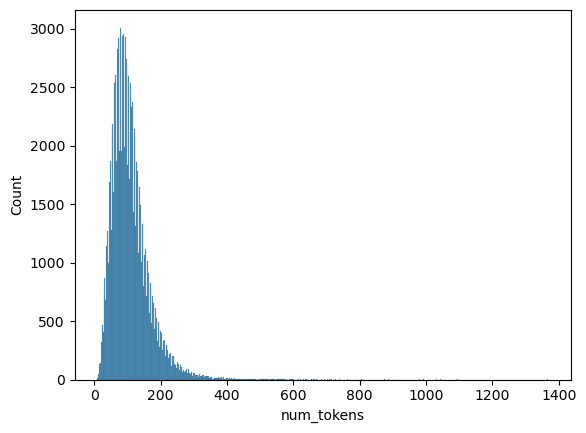

In [95]:
sns.histplot(filtered_recipes['num_tokens']);

The number of tokens in `CleanRecipeTextData` doesn't ever exceed 1400. I won't further mutilate the dataset (we did that for the test phase).

So we have 108,907 recipes to run `ada-002` on their cleaned text data.

### 2.3.2. Connecting to the API <a class ='author' id='2.3.2'></a>

In this section we will set our API key and send a request to verify that we can send a request.
To do so, you need to get yourself a private API key first by signing up to create your account.

In [18]:
import tiktoken #pip install
import openai   #pip install

# Copy and paste your personal api key inbetween the quotation marks and then execute the below code
openai.api_key = "<insert your API key>"

In [19]:
# list models as a quick test
models = openai.Model.list()

# print the first model's id
print(models.data[0].id)

babbage


In [20]:
# Test if we can send a request

completion = openai.Completion.create(model="ada", prompt="Hello world")
print(completion['choices'][0].text)

 (it's gonna be unfair if you're hitting 1,000k today!),


In [21]:
# Import `get_embedding`

from openai.embeddings_utils import get_embedding

In [22]:
# Embedding model parameters

embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # This is the encoding for text-embedding-ada-002
max_tokens = 8000

In [23]:
from tenacity import retry, stop_after_attempt, wait_exponential

# Define the retry strategy using Tenacity
@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=30))

def get_embedding(text, engine="text-embedding-ada-002"):
    text = text.replace("\n", " ")
    response = openai.Embedding.create(input=[text], model=engine)
    embeddings = response['data'][0]['embedding']
    return embeddings

In [108]:
import time

# Apply the get_embedding function with retries

start = time.time()

# DO NOT RUN THE BELOW CODE UNLESS YOU WANT TO GET THE EMBEDDINGS FOR YOURSELF
#filtered_recipes['ada_embeddings'] = filtered_recipes['CleanRecipeTextData'].apply(lambda x: get_embedding(x, engine=embedding_model))

end = time.time()

duration = end-start
print(duration)

# Start: 17:32
# End: 23:36

19781.220056533813


In [110]:
# filtered_recipes.to_pickle('recipes_with_ada_embeddings.pkl')

### 2.3.3. Inspect Embeddings<a class ='author' id='2.3.3'></a>

Now that we have word embeddings saved as a pickle file, we will read in the file and use it from now on.

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
# Load the embeddings

filtered_recipes = pd.read_pickle('recipes_with_ada_embeddings.pkl')

In [5]:
filtered_recipes.sample()

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,BerTopics,CleanRecipeTextData,num_tokens,ada_embeddings
101251,514698.0,Roasted Pumpkin &amp; Spinach Risotto,1620171,Satyne,Make and share this Roasted Pumpkin &amp; Spin...,[https://img.sndimg.com/food/image/upload/w_55...,Nuts/Seeds/Grains,[< 60 Mins],"[1 1⁄4, 2, 1, 1, 2, 1 1⁄2, 1 1⁄2, 1⁄4, 1⁄4, None]","[pumpkin, onion, garlic cloves, arborio rice, ...",NaN,506.2,15.1,2.7,5.5,109.7,83.7,4.7,5.7,12.2,4.0,[Preheat oven to 200c. Place pumpkin in a larg...,https://www.food.com/recipe/Roasted-Pumpkin-&a...,"[1 1⁄4, 2, 1, 1, 2, 1 1⁄2, 1 1⁄2, 1⁄4, 1⁄4, ]","[kg pumpkin, peeled and diced, tablespoons oil...",2014,3,21,23,60,NaN,-1_pepper_onion_garlic,"nutsseedsgrain< 60 Minskg pumpkin, peeled and ...",111,"[0.0038345817010849714, -0.016741473227739334,..."


Now let's run comparsions between our recipes:


In [6]:
sample_recipe = filtered_recipes[['CleanRecipeTextData','ada_embeddings']].iloc[13,:] # Row with index=1

print(sample_recipe['CleanRecipeTextData'])

vegetEuropean Low Cholesterol Healthy Spring Summer < 60 Mins OvenFrench baguette, sliced 1/4-1/2 inch thick to taste butter to taste garlic powder cup ricotta cheese to taste parmesan cheese to taste salt tomatoes (med-size) tablespoon olive oil fresh basil leavescut baguett slices butter sprinkl garlic powder piece bake till lightli golden brown mix garlic powder parmesan cheese salt ricotta cheese till love blend taste dice tomato small cubes add oliv oil small strip fresh basil leaves cut thin strips spread ricotta mixture gener cool garlic bread slices top tomato mixtur bake 350f 10 minutes enjoy


In [9]:
np.array(sample_recipe['ada_embeddings']).reshape(1, -1)

array([[ 0.02581417,  0.00287632,  0.01030848, ...,  0.00511126,
        -0.00907199, -0.03784844]])

Let's find the closest recipe to the sample recipe, in terms of instructions:

In [121]:
max_distance = 0
row_index = 0
similarities = pd.DataFrame(columns=['similarity_scores'])

# Convert the string representation of the sample_plot embeddings to an actual NumPy array
sample_plot_embeddings = np.array(sample_recipe['ada_embeddings']).reshape(1, -1)

# Iterate through each row and compute the cosine distance between the sample_plot and all other plots
for row_index in filtered_recipes.index:  
    
    # Convert the string representation of the array to an actual NumPy array
    cur_embeddings = np.array(filtered_recipes['ada_embeddings'].iloc[row_index]).reshape(1, -1)
    
    # Compute the cosine distance between the sample plot and the current plot
    cur_distance = cosine_similarity(sample_plot_embeddings, cur_embeddings)
    
    similarities.at[row_index,'similarity_scores'] = cur_distance[0,0]



similarities.sort_values('similarity_scores',ascending=False)

,similarity_scores
13,1.0
78708,0.950949
79685,0.944953
2669,0.942578
5983,0.937835
...,...
57650,0.744319
63551,0.74415
30572,-0.001898
28994,-0.003821


Let's compare the CleanInstructions of the sample recipe and the recipe closest to it according to the results above:

In [122]:
# The sample recipe's CleanInstructions

print(sample_recipe['CleanRecipeTextData'])

vegetEuropean Low Cholesterol Healthy Spring Summer < 60 Mins OvenFrench baguette, sliced 1/4-1/2 inch thick to taste butter to taste garlic powder cup ricotta cheese to taste parmesan cheese to taste salt tomatoes (med-size) tablespoon olive oil fresh basil leavescut baguett slices butter sprinkl garlic powder piece bake till lightli golden brown mix garlic powder parmesan cheese salt ricotta cheese till love blend taste dice tomato small cubes add oliv oil small strip fresh basil leaves cut thin strips spread ricotta mixture gener cool garlic bread slices top tomato mixtur bake 350f 10 minutes enjoy


In [123]:
# The closest recipe's CleanInstructions

filtered_recipes[['CleanRecipeTextData','ada_embeddings']].iloc[78708,:]['CleanRecipeTextData'] # Row with index=1

'vegetEuropean Low Cholesterol Healthy Summer < 15 Mins Easyloaf French bread lb roma tomatoes or 1 lb cherry tomatoes, cut into small pieces cup fresh basil, rolled together and sliced julienne garlic cloves, minced tablespoons extra virgin olive oil saltplace cut tomato bowl salt them let sit 10 minutes add garlic basil oliv oil stir combin let sit anoth 10 minutes cut french bread thick 1 inch slices grill slice toast slightli charred 1 minut per side top grill bread slice tomato mixtur serv immediately'

Let's now create a function that returns common words in two given strings. We can then apply it to our strings to find common words in them.

In [12]:
def find_common_words(str1, str2):
    # Tokenize the strings into words
    words1 = str1.split()
    words2 = str2.split()

    # Create sets of unique words
    set1 = set(words1)
    set2 = set(words2)

    # Find the common words using the intersection of the sets
    common_words = set1.intersection(set2)

    return common_words

**NOTE:** It's important to note that this function only gives us vizibility into the exact word matching between given strings, BUT the there's more to this when comparing them using the ada-002 embeddings: they capture the semantic of the terms in the strings as well. So naturally the string 'beef bacon grill' is more similar to 'chicken barbeque' than to 'potato char', even thouh none of these strings has any exact words in common with the other two. And all of these are closer to one another in comparsion to 'North Korea nuclear arsenal'. Let's take a look:

In [37]:
str1 = 'beef bacon grill'
str2 = 'chicken barbeque'
str3 = 'potato char'
str4 = 'North Korea nuclear arsenal'


strings = [str1,str2,str3,str4]

for i in strings:
    for j in strings:
        if i!=j:
            print(f"The similarity of '{i}' to '{j}' is: {cosine_similarity(np.array(get_embedding(i)).reshape(1, -1),np.array(get_embedding(j)).reshape(1, -1))[0,0]}")

The similarity of 'beef bacon grill' to 'chicken barbeque' is: 0.8538504508409608
The similarity of 'beef bacon grill' to 'potato char' is: 0.7906288794903815
The similarity of 'beef bacon grill' to 'North Korea nuclear arsenal' is: 0.7297995607512446
The similarity of 'chicken barbeque' to 'beef bacon grill' is: 0.8538504508409608
The similarity of 'chicken barbeque' to 'potato char' is: 0.8165535221019657
The similarity of 'chicken barbeque' to 'North Korea nuclear arsenal' is: 0.7710775296098366
The similarity of 'potato char' to 'beef bacon grill' is: 0.7905747378254895
The similarity of 'potato char' to 'chicken barbeque' is: 0.8165204851713237
The similarity of 'potato char' to 'North Korea nuclear arsenal' is: 0.7253536775734889
The similarity of 'North Korea nuclear arsenal' to 'beef bacon grill' is: 0.729817071166078
The similarity of 'North Korea nuclear arsenal' to 'chicken barbeque' is: 0.7710775296098366
The similarity of 'North Korea nuclear arsenal' to 'potato char' is: 

Now let's apply our function to the sample recipe and its closest recipe, and analyze the results:

In [38]:
sample_recipe['CleanRecipeTextData']

'vegetEuropean Low Cholesterol Healthy Spring Summer < 60 Mins OvenFrench baguette, sliced 1/4-1/2 inch thick to taste butter to taste garlic powder cup ricotta cheese to taste parmesan cheese to taste salt tomatoes (med-size) tablespoon olive oil fresh basil leavescut baguett slices butter sprinkl garlic powder piece bake till lightli golden brown mix garlic powder parmesan cheese salt ricotta cheese till love blend taste dice tomato small cubes add oliv oil small strip fresh basil leaves cut thin strips spread ricotta mixture gener cool garlic bread slices top tomato mixtur bake 350f 10 minutes enjoy'

In [39]:
filtered_recipes[['CleanRecipeTextData','ada_embeddings']].iloc[78708,:]['CleanRecipeTextData']

'vegetEuropean Low Cholesterol Healthy Summer < 15 Mins Easyloaf French bread lb roma tomatoes or 1 lb cherry tomatoes, cut into small pieces cup fresh basil, rolled together and sliced julienne garlic cloves, minced tablespoons extra virgin olive oil saltplace cut tomato bowl salt them let sit 10 minutes add garlic basil oliv oil stir combin let sit anoth 10 minutes cut french bread thick 1 inch slices grill slice toast slightli charred 1 minut per side top grill bread slice tomato mixtur serv immediately'

In [14]:
# Sample strings
string1 = sample_recipe['CleanRecipeTextData']
string2 = filtered_recipes[['CleanRecipeTextData','ada_embeddings']].iloc[78708,:]['CleanRecipeTextData']

# Find common words
common_words = find_common_words(string1, string2)
print(common_words)

{'garlic', 'fresh', 'Mins', 'mixtur', 'oil', '<', 'add', '10', 'cut', 'inch', 'Cholesterol', 'sliced', 'basil', 'olive', 'top', 'vegetEuropean', 'tomato', 'thick', 'tomatoes', 'small', 'oliv', 'minutes', 'Healthy', 'bread', 'Summer', 'salt', 'Low', 'slices', 'cup'}


#### Analysis
As we can see, the two strings have several ingredients in common, such as the following:

- garlic' 
- 'oil'
- 'basil'
- 'olive'
- 'tomato'
- 'bread'

Moreover, some contextual terms such as the following have been found as common terms:

- 'sliced'
- 'vegetEuropean'
- 'thick'
- 'healthy'
- 'Summer'

We couldn't get much of the latter in our previous embeddings as they weren't incorporated into the text data fed to `ada-002`. (We also noted that some recipes couldn't get much ingredient info either since the ingredients were not mentioned in the recipe instructions.)

Aside from this, we get some terms that are semantically relevant but don't have exact matches in both strings:

**Similar Food Ingredients:**

- "French baguette" (String 1) vs. "French bread" (String 2)
- "ricotta cheese" (String 1) vs. "extra virgin olive oil" (String 2)
- "parmesan cheese" (String 1) vs. "fresh basil" (String 2)
- "tomatoes" (String 1) vs. "roma tomatoes" or "cherry tomatoes" (String 2)
- "garlic powder" (String 1) vs. "garlic cloves, minced" (String 2)
- "salt" (String 1) vs. "saltplace cut tomato bowl salt them" (String 2)

**Cooking Techniques:**

- "bake till lightli golden brown" (String 1) vs. "grill slice toast slightli charred" (String 2)
- "sprinkl garlic powder" (String 1) vs. "add garlic basil oliv oil stir combin" (String 2)

**Descriptive Words:**

- "thin strips" (String 1) vs. "sliced julienne" (String 2)
- "small cubes" (String 1) vs. "cut into small pieces" (String 2)

**Cooking Times:**

- "< 60 Mins" (String 1) vs. "< 15 Mins" (String 2)

Altogether, the it seems that two recipes are very similar in various ways, both the exact terms used in their text data, and the semantically similar (though, not exact matching) terms in them.

Let's apply our function to the next closest recipe to recipe 13:

In [15]:
filtered_recipes[['CleanRecipeTextData','ada_embeddings']].iloc[589,:]['CleanRecipeTextData'] # Row with index=1

'lunchsnackMeat < 15 Mins Easyslices corned beef slice swiss cheese slices dark rye or 2 slices pumpernickel bread tablespoons sauerkraut tablespoons thousand island dressing tablespoons butterput two slice corn beef 1 swiss chees one piec bread heap sauerkraut spread dress sauerkraut put 2 slice corn beef top piec bread melt butter skillet griddl medium heat grill sandwich side serv warm'

In [16]:
string1 = sample_recipe['CleanRecipeTextData']
string3= filtered_recipes[['CleanRecipeTextData','ada_embeddings']].iloc[589,:]['CleanRecipeTextData']

find_common_words(string1, string3)

{'<', 'Mins', 'bread', 'butter', 'cheese', 'slices', 'spread', 'top'}

Aside from the exact matchings found above, we have the following conceptually relevant terms as well, even though they don't have exact matching in both strings:

In the given strings, some words and phrases that are semantically similar but not exact matches are:

**Similar Food Ingredients:**

- "French baguette" (String 1) vs. "dark rye" or "pumpernickel bread" (String 2)
- "butter" (String 1) vs. "butterput" (String 2)
- "garlic powder" (String 1) vs. "thousand island dressing" (String 2)
- "ricotta cheese" (String 1) vs. "swiss cheese" (String 2)
- "parmesan cheese" (String 1) vs. "sauerkraut" (String 2)
- "salt" (String 1) vs. "tablespoons sauerkraut" (String 2)
- "olive oil" (String 1) vs. "butter skillet" (String 2)
- "fresh basil leaves" (String 1) vs. "grill sandwich side" (String 2)
- "garlic bread" (String 1) vs. "grill sandwich" (String 2)


**Descriptive Words:**

- "< 60 Mins" (String 1) vs. "< 15 Mins" (String 2)
- "to taste" (String 1) vs. "tablespoons" (String 2)
- "small cubes" (String 1) and "thin strips" (String 1) vs. "slices" (String 2)

## 2.4. Creating a Recommender System<a class ='author' id='2.4'></a>

Now that we have tested our embeddings and functions, we can re-define the two functions that we used in our final recommendation system in Phase 1 of the notebook. 

First, we need to define a function that takes a text input and returns embeddings generated by the `OpenAI`'s ada model.

In [40]:
def ada_embeddings(text):
    response = openai.Embedding.create(
        model="text-embedding-ada-002",
        input=text,
    )
    return np.array(response['data'][0]['embedding'])

The second function takes an input and throws out recipes the top 5 recipes most similar to it:


In [41]:
from heapq import nlargest

def most_similar_recipes(user_input, df, n=5):
    # Step 1: Get the embeddings for the user_input
    input_embeddings = ada_embeddings(user_input)

    # Step 2: Calculate the similarity between user_input and each row in the DataFrame
    similarities = []

    for index, row in df.iterrows():
        cur_embeddings = row['ada_embeddings']
        similarity = cosine_similarity(np.array(input_embeddings).reshape(1, -1), np.array(cur_embeddings).reshape(1, -1))
        similarities.append((similarity, index))

    # Step 3: Find the top n most similar recipes using heapq's nlargest function
    top_n_similarities = nlargest(n, similarities)

    # Step 4: Extract the indices of the top n most similar recipes
    top_n_indices = [index for similarity, index in top_n_similarities]

    # Step 5: Return the DataFrame rows corresponding to the top n indices
    return df.loc[top_n_indices]

Now, let's test our functions to see if they work well. We can use the following sample user input:

In [42]:
user_input = (
    "Give me a recipe with chicken, bacon and eggs in it." 
)
top_5_similar_recipes = most_similar_recipes(user_input, filtered_recipes)
top_5_similar_recipes

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,BerTopics,CleanRecipeTextData,num_tokens,ada_embeddings
71524,351613.0,BLT Egg Wrap,883095,Chef mariajane,"This is a quick and easy, and also delicious, ...",[https://img.sndimg.com/food/image/upload/w_55...,Breakfast/Brunch,"[Vegetable, < 15 Mins]","[1, 1, 1⁄4, None, 1, 2, 1, 2]","[egg, onion powder, low-fat tortilla, low-fat ...",1.0,78.2,4.8,1.6,186.0,73.9,1.8,0.4,0.8,6.6,1.0,[Cook bacon in non-stick skillet over medium h...,https://www.food.com/recipe/BLT-Egg-Wrap-351613,"[1, 1, 1⁄4, , 1, 2, 1, 2]","[slice chicken bacon or 1 slice turkey bacon, ...",2009,1,23,17,7,5.00,6_mayonnaise_boiled_crabmeat,breakfastbrunchVegetable < 15 Minsslice chicke...,97,"[-0.008318441919982433, -0.01105539035052061, ..."
79421,391828.0,Cobb Salad,1072593,gailanng,Make and share this Cobb Salad recipe from Foo...,[https://img.sndimg.com/food/image/upload/w_55...,Main Dish,"[Chicken, Poultry, Vegetable, Meat, Weeknight,...","[8, 3, 1, 3, 2, 3⁄4, 1, 1 1⁄2, 1, None]","[bacon, eggs, lettuce, chicken meat, tomatoes,...",7.0,173.3,12.4,4.7,105.7,296.1,8.6,4.2,2.5,9.1,6.0,"[Divide shredded lettuce among plates., Evenly...",https://www.food.com/recipe/Cobb-Salad-391828,"[8, 3, 1, 3, 2, 3⁄4, 1, 1 1⁄2, 1, ]","[slices bacon, cooked, drained and crumbled, e...",2009,9,25,14,10,4.14,-1_pepper_onion_garlic,main dishChicken Poultry Vegetable Meat Weekni...,74,"[-0.0035131655167788267, -0.00453499099239707,..."
26776,141154.0,Crock Pot Swiss Cheese Chicken,195916,TERRY B.,Make and share this Crock Pot Swiss Cheese Chi...,[https://img.sndimg.com/food/image/upload/w_55...,Chicken,"[Chicken, Poultry, Meat, Beginner Cook, Easy]","[2, 4, 4, 1, 1, 1, 1, 4]","[potatoes, boneless chicken breasts, garlic cl...",1.0,619.3,27.0,10.4,130.5,718.5,48.4,5.5,4.4,45.3,4.0,"[In skillet cook bacon until crispy, remove an...",https://www.food.com/recipe/Crock-Pot-Swiss-Ch...,"[2, 4, 4, 1, 1, 1, 1, 4]","[slices turkey bacon, potatoes, quartered, bon...",2005,10,12,16,380,5.00,-1_pepper_onion_garlic,chickenChicken Poultry Meat Beginner Cook Easy...,74,"[0.017721202224493027, -0.023005293682217598, ..."
10131,60641.0,Famous Eggs and Bacon!,80047,lilbubblegurl,Make and share this Famous Eggs and Bacon! rec...,[https://img.sndimg.com/food/image/upload/w_55...,Breakfast/Brunch,"[< 15 Mins, Easy]","[1⁄2, 1⁄8, 2, 1]","[milk, eggs, eggs, cheese]",7.0,130.7,9.4,5.2,112.2,307.4,2.9,0.0,0.2,8.6,4.0,[Put 1/4 cup of bacon in the bottom of the pan...,https://www.food.com/recipe/Famous-Eggs-and-Ba...,"[1⁄2, 1⁄8, 2, 1]","[cup cooked bacon, crumbled, divided, cup milk...",2003,4,22,20,7,3.86,56_blue_cheddar_cheese,"breakfastbrunch< 15 Mins Easycup cooked bacon,...",44,"[0.0049086022190749645, -0.009938988834619522,..."
79828,394201.0,Skillet Corn Scramble,542159,Debbwl,A hearty scrambled egg dish that is good for s...,[https://img.sndimg.com/food/image/upload/w_55...,Breakfast/Brunch,[< 15 Mins],"[5, 5, 1⁄3, 1⁄4, 1, 1⁄2, 1⁄4, 1⁄8, 2, 1 1⁄2, N...","[bacon, eggs, milk, green pepper, onion, salt,...",6.0,171.0,9.7,3.2,193.7,401.7,12.8,1.5,3.2,9.5,5.0,"[In fry pan, cook bacon until crisp., Drain on...",https://www.food.com/recipe/Skillet-Corn-Scram...,"[5, 5, 1⁄3, 1⁄4, 1, 1⁄2, 1⁄4, 1⁄8, 2, 1 1⁄2, ]","[slices bacon, eggs, slightly beaten, cup milk...",2009,10,12,17,15,4.50,-1_pepper_onion_garlic,"breakfastbrunch< 15 Minsslices bacon eggs, sli...",62,"[-0.002576525555923581, -0.013893754221498966,..."


Let's inspect the first one:

In [44]:
top_5_similar_recipes.iloc[0]['CleanRecipeTextData']

'breakfastbrunchVegetable < 15 Minsslice chicken bacon or 1 slice turkey bacon, cooked egg teaspoon onion powder salt and pepper small low-fat tortilla teaspoons low-fat mayonnaise leaf lettuce tablespoons tomatoes, dicedcook bacon nonstick skillet medium heat microwav crisp fold half set aside wipe skillet clean whisk togeth egg onion powder salt pepper small bowl pour mixtur skillet cook stir slightli medium heat mxture begin set gentli move spatula across bottom side skillet form large soft curds cook egg thicken visibl liquid egg remain still moist spread tortilla mayonnaise place lettuc top add bacon egg tomato fold wrap serve'

It's needless to say how similar this is to our user input: 'chicken', 'bacon', and 'egg' appear in both.

Remember this is what in our previous recommender system:

    'combin first five ingredi mix well thi done well advance spread mixtur toast top bacon'
   
Let's try a more complicated input: I'm just copying most of the text data addociated to a recipe from this external link: https://themodernproper.com/30-best-ground-beef-recipes

In [50]:
user_input = (
"Easy Ground Beef Recipes with Few Ingredients Thai Basil Beef (cover photo). A speedy, savory Thai beef basil stir fry that’s\
just a bit spicy and really hits the spot. Gingery Ground Beef (Soboro Donburi). Five ingredients, a few minutes and a hot \
skillet, and you’ll be digging into a delicious soboro donburi, a gingery ground beef that reminds us that the best Japanese \
recipes are often the simplest. Crock-Pot Taco Meat. Just three-ingredients and the use of our trusty slow-cooker make this \
Crock-Pot beef taco meat recipe an easy win. Taco Pizza. Two classic family favorites, pizza and tacos, come together in this\
super easy weeknight meal that is destined to become a favorite in your home. Ground Beef Burger and Sandwich Recipes Classic\
Cheeseburger with Secret Sauce. A perfectly soft bun, quality, juicy ground beef that is seasoned well, plenty of cheese,\
caramelized onions and a really good secret sauce are the key to this truly classic cheeseburger recipe. Patty Melt. As diner\
sandwiches go, the melty, meaty, oniony perfection that is the patty melt reigns supreme—if you know, you know. And if you don’t\
know, well, welcome to the club. Meatball Sub Sandwich. Big juicy, tender meatballs simmered in marinara sauce (store-bought\
or homemade—either works!) stuffed into garlicky hoagie rolls, topped with mozzarella and broiled to melty, bubbly perfection.\
Beef Sliders. These juicy ground beef sliders—slathered with a homemade bright and lemony sun-dried tomato mayo, spicy pickles,\
and fresh arugula—prove that bigger doesn’t always equal better. Low-Carb Bacon Burger with Guacamole. You’ll forget all about\
the missing bun while devouring this juicy, keto-friendly bacon guacamole burger loaded with veggies and jalapeno aioli!"
)

top_5_similar_recipes = most_similar_recipes(user_input, filtered_recipes)
top_5_similar_recipes

,RecipeId,Name,AuthorId,AuthorName,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions,url,ingred_quants,ingred_items,YearPublished,MonthPublished,DayPublished,HourPublished,TotalMinutes,CorrectAggregatedRating,BerTopics,CleanRecipeTextData,num_tokens,ada_embeddings
43303,218875.0,Garlic Lover's Burger,178711,Buckeye Karen,"If you're like me, you just can't get enough o...",[https://img.sndimg.com/food/image/upload/w_55...,Meat,"[< 15 Mins, Beginner Cook, Easy]","[1, 1⁄8, 3, 1⁄4, 3, 1 1⁄2, None, 4, None, None...","[ground beef, dried cilantro, garlic, honey, s...",1.0,449.9,19.0,7.1,77.1,1039.0,42.4,1.3,20.5,27.3,4.0,[Mix all ingredients together (except ground p...,https://www.food.com/recipe/Garlic-Lover's-Bur...,"[1, 1⁄8, 3, 1⁄4, 3, 1 1⁄2, , 4, , , , ]","[lb ground beef (or chuck or sirloin), cup dri...",2007,3,26,20,15,5.0,-1_pepper_onion_garlic,meat< 15 Mins Beginner Cook Easylb ground beef...,170,"[-0.007803387939929962, 0.002627050504088402, ..."
107680,536579.0,Korean Ground Beef and Rice Bowls,972011,Yearbook Mom,Make and share this Korean Ground Beef and Ric...,[https://img.sndimg.com/food/image/upload/w_55...,Quick and Easy,[Easy],"[1, 3, 1⁄4, 1⁄4, 2, 1⁄4, 1⁄4, 1⁄4, 2, 1⁄4, 1]","[lean ground beef, garlic cloves, brown sugar,...",NaN,407.5,13.8,5.0,73.7,611.4,42.9,0.7,13.8,26.0,4.0,[1. In a large skillet cook the ground beef an...,https://www.food.com/recipe/Korean-Ground-Beef...,"[1, 3, 1⁄4, 1⁄4, 2, 1⁄4, 1⁄4, 1⁄4, 2, 1⁄4, 1]","[lb lean ground beef (90% lean), garlic cloves...",2018,7,30,18,20,NaN,-1_pepper_onion_garlic,quick easiEasylb lean ground beef (90% lean) g...,89,"[-0.003680585417896509, -0.00722745293751359, ..."
104057,525697.0,Thai Basil Beef,403989,Papagayita,"Delicious, adaptable recipe that's great for u...",[https://img.sndimg.com/food/image/upload/w_55...,Meat,"[Thai, Asian, Weeknight, < 30 Mins, Easy]","[1, 2, 3 -4, 1, 1, 1 -2, 1, 1, 2, 1⁄4, 1, 1⁄2,...","[ground beef, garlic cloves, onion, bell peppe...",1.0,302.6,19.7,7.1,77.6,929.4,7.6,1.3,3.7,23.1,4.0,[Heat a large frying pan over medium high heat...,https://www.food.com/recipe/Thai-Basil-Beef-52...,"[1, 2, 3 -4, 1, 1, 1 -2, 1, 1, 2, 1⁄4, 1, 1⁄2, ]","[lb ground beef, teaspoons sesame oil, garlic ...",2016,1,24,15,25,5.0,-1_pepper_onion_garlic,meatThai Asian Weeknight < 30 Mins Easylb grou...,139,"[-0.004620139487087727, -0.007158639840781689,..."
78319,385719.0,Spanish Rice With Beef,1002521,Box O Wine,"Instead of roasting the red peppers, I just cu...",[https://img.sndimg.com/food/image/upload/w_55...,Main Dish,"[Meat, Weeknight, < 60 Mins, Easy]","[1, 1, 2, 1, 1, 1, 2, 1, 1⁄4, 1⁄4, 1⁄4, 2, 1⁄8]","[lean ground beef, garlic cloves, yellow onion...",NaN,338.8,15.1,5.1,73.7,80.0,23.9,1.3,1.5,25.1,4.0,"[In a large skillet, cook ground beef over med...",https://www.food.com/recipe/Spanish-Rice-With-...,"[1, 1, 2, 1, 1, 1, 2, 1, 1⁄4, 1⁄4, 1⁄4, 2, 1⁄8]","[lb lean ground beef, tablespoon vegetable oil...",2009,8,17,3,50,NaN,-1_pepper_onion_garlic,main dishMeat Weeknight < 60 Mins Easylb lean ...,147,"[0.004986213985830545, -0.0030652128625661135,..."
49605,247296.0,Stuffed Burger,265694,Brisket in Roses,"I was reading a recipe yesterday on zaar, and ...",[https://img.sndimg.com/food/image/upload/w_55...,Meat,"[< 30 Mins, Beginner Cook, Easy]","[2, 5, 2, 1, None, None, 8, None, None, None, ...","[ground beef, scallions, garlic powder, cayenn...",2.0,512.7,29.2,10.8,114.5,554.7,23.5,1.6,3.3,36.6,6.0,[I actually made a spicy mayo for this burger ...,https://www.food.com/recipe/Stuffed-Burger-247296,"[2, 5, 2, 1, , , 8, , , , , , 6]","[lbs ground beef (not the lean kind, it needs ...",2007,8,19,18,20,4.0,-1_pepper_onion_garlic,meat< 30 Mins Beginner Cook Easylbs ground bee...,123,"[-0.01129306759685278, -0.0018322287360206246,..."


In [51]:
top_5_similar_recipes.iloc[0]['CleanRecipeTextData']

'meat< 15 Mins Beginner Cook Easylb ground beef (or chuck or sirloin) cup dried cilantro (or a handful of fresh chopped cilantro) tablespoons minced garlic cup honey tablespoons soy sauce tablespoons ginger paste fresh ground pepper (peppercorn medley) buns (one for each patty) fresh minced onions (optional) or dried parsley (optional) salt (optional) canned black beans (small can, drained and rinsed) (optional) prepared spaghetti sauce (optional) or pizza sauce (optional)mix ingredi togeth except ground pepper form patti prefer size thickness grill burger prefer done rare welldone crack fresh ground pepper burger grill desired salt burger tast top chees last minut grill melt burger burger alreadi soy sauce find salt unnecessary place burger favorit bun add toppings dig in options add option ingredi mix grilling fresh minc onion add alot flavor everyon like onions ad black bean easi way bulk mix add great fiber nutrition might wish tri half first time unsur like them burger verg meatlo

Just from a first glance we realize that both of these recipes are burger recipes.

**The user input recipe:**
<img src="https://images.themodernproper.com/billowy-turkey/production/posts/2019/Classic-Cheeseburger-With-Secret-Sauce-13.jpg?w=1800&q=82&fm=jpg&fit=crop&dm=1606105565&s=28009d0ef053def9f7f450310ebce714" alt="Beautiful Sunset" width="400" height="300">


**The top-recommended recipe:**

![Burger2](https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/21/88/75/pic5KXgef.jpg)

So far so good!! Let's take a look at the text data:

In [52]:
# Find exact matches

String1 = user_input
String2 = top_5_similar_recipes.iloc[0]['CleanRecipeTextData']
find_common_words(String1, String2)

{'a',
 'and',
 'beef',
 'bun',
 'burger',
 'fresh',
 'ground',
 'in',
 'melt',
 'of',
 'onions',
 'pizza',
 'sauce'}

#### Similar Terms

Aside from the the exact matches that we see above, here are some words and phrases in the two strings that are semantically similar (where `String 1` = user_input, and `String 2` = the first recommneded similar recipe):

- "ground beef" (both strings)
- "ginger paste" (String 1) vs. "tablespoons ginger paste" (String 2)
- "soy sauce" (both strings)
- "fresh ground pepper" (String 1) vs. "fresh ground pepper (peppercorn medley)" (String 2)
- "cilantro" (String 1) vs. "dried cilantro (or a handful of fresh chopped cilantro)" (String 2)
- "buns" (both strings)
- "onions" (String 1) vs. "fresh minced onions (optional)" (String 2)
- "spaghetti sauce" (String 2) vs. "marinara sauce" (String 1)
- "grill burger" (both strings)

#### Categories

We can also see that most of the recommended recipes fall under the categories 'Meat' or "Main Dish' (containing meaty contents) (in `RecipeCategory`). The BerTopic categories don't seem much helpful here: even though they're all in the topic `-1_pepper_onion_garlic`, this topic (starting with `-1` is the topic that BerTopic throws in it things that it cannot properly categorize). This might have to do with the fact that the topics that we have imported from BerTopic are reduced from over 2,400 to 300, which means that many of the more nuanced categoris were tossed into `-1_pepper_onion_garlic` (see the notebook on topic modeling). We might be able to mitigate the issue if we use the original 2,400 topics; I won't pursue this here, however.

Alright! I think our recommender system is doing fairly well. Check out the other top-recommended recipes to find out that they're indeed very similar (pretty beefy or burgury).

## 3. Conclusion <a class ='author' id='conc'></a>
......

We are now ready to use the embeddings and our recommender system in more advanced systems that take into account other recipe feraturs, such as nutritional facts. We will do this in another notebook.